# Discretization of time-varying CMJ generating function
Author: *Frederik Mølkjær Andersen*

Companion notebook for the report *Efficient computation of the probability generating function in a general branching process model for infectious diseases*

This notebook should be read in conjunction with the report.

A `.ipynb` file constructing this pdf can be found on [my GitHub (molkjar)](https://github.com/molkjar/cmj_pgf).

This notebook showcases the two implementations of the generating function for the time-varying presented in Section 6 in the report and the computation of the probability mass function from it as presented in Section 2.3. We will focus on the branching process counting prevalence under a negative binomial infection process. 

In our example assume that $L^\tau \sim \Gamma(5, \theta(\tau))$ where $\theta(\tau)$ is a $\tau$-dependent *scale*-parameter
$$
\theta(\tau) := \frac{1}{1 + 0.01\tau}
$$
and that individual infectiousness follows a $\Gamma(3, 1)$ distribution. We assume that the time-varying transmission rate $\rho$ is assumed to be given as
$$
\rho(t) := 1.5 + \sin(0.15 t).
$$

Despite the choice of counting characteristic, infection process etc. above the functions presented here can handle all cases mentioned in the report, in particular it can compute the generating function for cumulative incidence and use the Poisson infection process.

Most of our implementation is done through storing in and computing on matrices, here implemented as two-dimensional `numpy` arrays. Distribution related functions and a bit of linear algebra magic is drawn from `scipy` and plotting is done using `matplotlib`.

In [10]:
import numpy as np
from scipy.stats import gamma
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt

In [187]:
def G(t, tau):
  return gamma.cdf(t, a = 6, scale = 1 / (1 + 0.01 * tau))

def V(t):
  return gamma.cdf(t, a = 3, scale = 1)

def rho(t):
  return 1.5 + np.sin(0.175 * t)

We now define a helper function which returns all the matrices, functions and alike used in the computation of the generating function, the definitions follow from Section 6 of the report. The result is saved in a list. In particular this lets us precompute all of these quantities which are invariant of $s$, the argument of the generating function.

In [24]:
def pgf_prep(N, Delta, G, V, rho, phi, count="prev", inf_proc="negbin"):
  if inf_proc == "negbin":
    def psi(z):
      return - phi * (np.log(phi + 1 - z) - np.log(phi))
  if inf_proc == "pois":
    def psi(z):
      return z - 1

  def q_1(z, s):
    return s * np.exp(z)

  if count == "prev":
    def q_2(z, s):
      return np.exp(z)
  if count == "ci":
    def q_2(z, s):
      return s * np.exp(z)

  Gbar_t = np.tril(np.tile(np.arange(0, N+1) * Delta, (N+1, 1)).T)
  Gbar_tau = np.tril(toeplitz(np.arange(0, N+1) * Delta))
  Gbar = 1 - G(Gbar_t - Gbar_tau, Gbar_tau)

  D_t = np.triu(np.tile(np.arange(N, -1, -1) * Delta, (N, 1)))
  D_tau = np.triu(np.tile(np.arange(0, N) * Delta, (N+1, 1)).T)
  
  DV = -rho(D_t[:, :-1] + D_tau[:, :-1]) * np.diff(V(D_t))
  DG = -np.diff(G(D_t, D_tau))

  return [N, psi, q_1, q_2, Gbar, DV, DG]  

## Algorithm 1
We are ready to implement Algorithm 1 from the report. The algorithm involves three nested for-loops so will probably take a while to finish, at least for high $N$. The function takes two arguments, the generating function argument $s$ and the resulting list from `pgf_prep` above.

In [25]:
def pgf_direct(s, prep_list):
  N, psi, q_1, q_2, Gbar, DV, DG = prep_list

  F = np.zeros((N+1, N+1), dtype=np.complex_)
  F[:, 0] = s

  for n in range(1, N+1):
    for i in range(1, n+1):
      int_1 = Gbar[n, i] * q_1(np.sum(psi(F[n, 0:i]) * DV[n-i, (N-i):N]), s)
      
      int_2 = 0 + 0j
      for j in range(i):
        int_2_in = np.sum(psi(F[n, (j+1):i]) * DV[n-i, (N-i+j+1):N])
        int_2 += q_2(int_2_in, s) * DG[n-i, N-i+j]

      F[n, i] = int_1 + int_2

  return np.diag(F)

## Algorithm 2
Next we will use the vectorization scheme outlined in the report, `numpy` has a lot of nice array transformation features which we use an abundance of. This implementation contains only one for-loop (which we can't get rid of), so should be much faster than `pgf_direct`. Further vectorization over `s` is possible using three-dimensional arrays, however this takes up a lot of unnecessary memory and without much gain in speed, however the problem is embarrassingly parallelizable as computation for each $s$ is completely independent from each other.

Have in mind that both implementations do the exact same computations (with diregard to what happens in the parts of the matrices which are never acessed), so their results should be identical, up to some floating point error.

In [26]:
def pgf_vec(s, prep_list):
  N, psi, q_1, q_2, Gbar, DV, DG = prep_list
  
  F = np.zeros((N+1, N+1), dtype=np.complex_)
  F[:, 0] = s

  for i in range(1, N+1):
    B = psi(F[i:(N + 1), 0:i]) * DV[0:(N - i + 1), (N - i):N]
    B_1 = np.cumsum(B[:, ::-1], axis = 1)[:, ::-1]

    int_1 = Gbar[i:(N + 1), i] * q_1(B_1[:, 0], s)
    
    B_2 = np.concatenate((B_1[:, 1:i], np.zeros((B_1.shape[0], 1))), axis = 1)
    int_2 = np.sum(q_2(B_2, s) * DG[0:(N - i + 1), (N - i):N], axis = 1)

    F[i:(N + 1), i] = int_1 + int_2

  return np.diag(F)

## Computing the probability mass function
As described in Section 2.3 of the report we can take advantadge of the Cauchy integral and fast Fourier transform to compute the probability mass function from the generating function. Below is a function that takes the `pgf_prep` list of object and computes the derivatives of the generating function and thus the mass function. To take care numerical errors, the mass function is normalized before it is returned.

As mentioned above, computing of the generating function at many values of $s$ is embarrassingly parallelizable, however parallelization is not trivial in a Jupyter Notebook, so we will let it be as is.

In [27]:
def pmfft(M, prep_list):
  pgf = np.array(list(map(lambda m: pgf_vec(np.exp(2.0j*np.pi*m/M), prep_list), range(M))))
  fft = np.real(np.fft.fft(pgf, axis=0))
  pmf = fft * (fft >= 0)
  return pmf / np.sum(pmf, axis=0)

In practice we want to compute moments of the process for now we will investigate the mean of the process, however higher moments are easily found from the probability mass function.

In [205]:
def mean(pmf):
  M = np.shape(pmf)[0]
  loc = np.linspace(0, M-1, M)
  mn = np.sum(pmf.T * loc, axis = 1)
  return mn

## A test for correctness
A sanity check that our algorithms above are actually computing the generating function we are looking for. We use the previously developed algorithm for the mean of the process (Pakkanen, 2022) which is implemented below, and compare the mean computed from the generating function.

In [88]:
def quick_mean(N, Delta, G, V, rho):
  def h(t, tau):
    return 1 - G(t - tau, tau)
  
  def lam(t, tau):
    return rho(t + tau) * (V(t) - V(t-Delta)) * (1 - G(t, tau))
  
  fhat = np.zeros(shape = (N + 1, N + 1))

  for n in range(N + 1):
      for i in range(n + 1):
          if i == 0:
              fhat[n, i] = h(n * Delta, n * Delta)
          else:
              fhat[n, i] = h(n * Delta, (n - i) * Delta) + np.sum(fhat[n, i - np.arange(1, i + 1)] * lam(Delta * np.arange(1, i + 1), (n - i) * Delta))

  return np.diagonal(fhat)


We will generate the discretization over $N = 200$ time steps with step size $\Delta = 0.5$, i.e. simulating the epidemic until time $t=100$. The fast Fourier transform need a quite high number of terms, we use $M = 5000$, but remember that this task is easy to parallelise.

In [ ]:
N = 200
Delta = 0.5

mn = quick_mean(N, Delta, G, V, rho)

p_list = pgf_prep(N, Delta, G, V, rho, 1, inf_proc = "pois")
pmf = pmfft(5000, p_list)

[Text(0.5, 0, 'time'), Text(0, 0.5, 'absolute difference')]

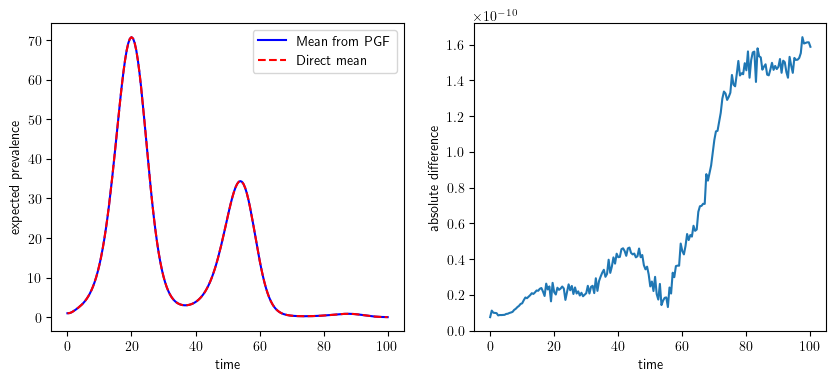

In [231]:
grid = Delta * np.arange(0, N+1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 4, forward=True)
ax1.plot(grid, mean(pmf), "b", label = "Mean from PGF")
ax1.plot(grid, mn, "r--", label = "Direct mean")
ax1.set(
  xlabel = "time",
  ylabel = "expected prevalence"
)
ax1.legend()

ax2.plot(grid, abs(mean(pmf) - mn))
ax2.set(
  xlabel = "time",
  ylabel = "absolute difference"
)


We see that the two approaches only differ by some floating point error.